<a href="https://colab.research.google.com/github/abdulkadirturkan/geneticAlgorithmClass/blob/main/Genetik_Algoritma_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
#Model tanımları(Ders, Eğitmen, Sınıf, Zaman)

class Course:
    def __init__(self, code, name, students, theory_hours, lab_hours):
        self.code = code
        self.name = name
        self.students = students
        self.theory_hours = theory_hours
        self.lab_hours = lab_hours

class Lecturer:
    def __init__(self, name, course_codes, preferred_time_slots, availability):
        self.name = name
        self.courses = course_codes
        self.preferred_time_slots = preferred_time_slots
        self.availability = availability
        self.preferred_days, self.preferred_hours = self.parse_availability(availability)

    def parse_availability(self, availability):
        days, hours = availability.split()
        start_hour, end_hour = [int(h.split(":")[0]) for h in hours.split("-")]
        return days.split("-"), range(start_hour, end_hour + 1)

class Room:
    def __init__(self, number, capacity, room_type, availability):
        self.number = number
        self.capacity = capacity
        self.room_type = room_type
        self.availability = availability

class TimeSlot:
    def __init__(self, day, time_slot):
        self.day = day
        self.time_slot = time_slot

In [ ]:
# Ders Programı Gösterim için class(Takvim)
class Schedule:
  # Gerekli Parametreler(Ders, Eğitmen, Sınıf, Zaman, Fitness)
    def __init__(self, courses, lecturers, rooms, time_slots):
        self.courses = {course.code: course for course in courses}
        self.lecturers = lecturers
        self.rooms = rooms
        self.time_slots = time_slots
        self.schedule = {}
        self.fitness = 0
  # Gösterim(Ders Kodlarına göre; Ders saatleri(Gün ve Zaman aralığı), Lab saatleri(Gün ve Zaman aralığı), Dersin işlendiği sınıf, Labın işlendiği sınıf)
    def initialize(self):
        for course in self.courses.values():
            theory_slots = self.get_consecutive_slots(course.theory_hours, course.code)
            lab_slots = self.get_consecutive_slots(course.lab_hours, course.code, is_lab=True)

            room = random.choice([r for r in self.rooms if r.room_type == "Derslik"])
            lab_room = random.choice([r for r in self.rooms if r.room_type == "Lab"])

            self.schedule[course.code] = {
                "theory": theory_slots,
                "lab": lab_slots,
                "room": room,
                "lab_room": lab_room
            }
  # Eğitmenin tercih ettiğin gün ve saatlerin ayrımı
    def get_consecutive_slots(self, hours_needed, course_code, is_lab=False):
      lecturer = next((l for l in self.lecturers if course_code in l.courses), None)
      preferred_days = lecturer.preferred_days if lecturer else ["Pazartesi", "Salı", "Çarşamba", "Perşembe", "Cuma"]
      preferred_hours = lecturer.preferred_hours if lecturer else range(8, 17)

      random.shuffle(preferred_days)

      for day in preferred_days:
          day_slots = [ts for ts in self.time_slots if ts.day == day and int(ts.time_slot.split(":")[0]) in preferred_hours]

          for start_index in range(0, len(day_slots) - hours_needed + 1):
              consecutive_slots = day_slots[start_index:start_index + hours_needed]
              if len(consecutive_slots) == hours_needed:
                  return consecutive_slots

      return []
  # Fitness fonksiyonunun hesaplanması
    def calculate_fitness(self):
      # 100 başlangıç
      self.fitness = 100
      for course_code, details in self.schedule.items():
          course = self.courses[course_code]
          room = details["room"]
          lab_room = details["lab_room"]
          lecturer = next((l for l in self.lecturers if course_code in l.courses), None)

          # Sınıf Kapasitesi kontrolü
          if room.capacity < course.students or lab_room.capacity < course.students:
              self.fitness -= 35

          # Ders tipine göre sınıfın tipi(Derslik veya Lab)
          if room.room_type != "Derslik":
              self.fitness -= 10
          if lab_room.room_type != "Lab":
              self.fitness -= 10

          # Eğitmenin Tercih aralığına göre Fitness ayarı
          if lecturer:
              for ts in details["theory"]:
                  if ts.day not in lecturer.preferred_days or int(ts.time_slot.split(":")[0]) not in lecturer.preferred_hours:
                      self.fitness -= 5
              for ts in details["lab"]:
                  if ts.day not in lecturer.preferred_days or int(ts.time_slot.split(":")[0]) not in lecturer.preferred_hours:
                      self.fitness -= 5

          # Lab ve Teori dersininin çakışmaması için
          if any(ts in details["lab"] for ts in details["theory"]):
              self.fitness -= 20

          # Derslerin Çakışmaması için(Aynı saatte aynı sınıfta ders olamaz, Aynı eğitmenin aynı saatte birden çok dersi olamaz, Dersin Labı ve Teorisi aynı anda olamaz)
          for other_course_code, other_details in self.schedule.items():
              if other_course_code != course_code:
                  other_lecturer = next((l for l in self.lecturers if other_course_code in l.courses), None)
                  if lecturer and other_lecturer and lecturer == other_lecturer:
                      if any(ts in details["theory"] + details["lab"] for ts in other_details["theory"] + other_details["lab"]):
                          self.fitness -= 10
                  if room == other_details["room"]:
                      if any(ts in details["theory"] for ts in other_details["theory"]):
                          self.fitness -= 10
                  if lab_room == other_details["lab_room"]:
                      if any(ts in details["lab"] for ts in other_details["lab"]):
                          self.fitness -= 10
    # Genetik algoritmadaki her gende gerçekleşen olayları görüntüleme
    def print_schedule(self):
        for course_code, details in self.schedule.items():
            print(f"Kurs: {course_code}")
            print(f"  Teori: {[f'{ts.day} {ts.time_slot}' for ts in details['theory']]}")
            print(f"  Lab: {[f'{ts.day} {ts.time_slot}' for ts in details['lab']]}")
            print(f"  Teori Sınıfı: {details['room'].number}")
            print(f"  Lab Sınıfı: {details['lab_room'].number}")
        print(f"Fitness: {self.fitness}\n")

In [ ]:
def tournament_selection(population, tournament_size):
    tournament = random.sample(population, tournament_size)
    tournament.sort(key=lambda schedule: schedule.fitness, reverse=True)
    return tournament[0]

def crossover(parent1, parent2):
    child1 = Schedule(parent1.courses.values(), parent1.lecturers, parent1.rooms, parent1.time_slots)
    child2 = Schedule(parent2.courses.values(), parent2.lecturers, parent2.rooms, parent2.time_slots)

    crossover_point = random.randint(0, len(parent1.courses) - 1)
    for i, course_code in enumerate(parent1.courses.keys()):
        if i < crossover_point:
            child1.schedule[course_code] = parent1.schedule[course_code]
            child2.schedule[course_code] = parent2.schedule[course_code]
        else:
            child1.schedule[course_code] = parent2.schedule[course_code]
            child2.schedule[course_code] = parent1.schedule[course_code]

    return child1, child2

def mutate(schedule, mutation_rate):
    for course_code, details in schedule.schedule.items():
        if random.random() < mutation_rate:
            total_hours_needed = schedule.courses[course_code].theory_hours + schedule.courses[course_code].lab_hours
            combined_slots = schedule.get_consecutive_slots(total_hours_needed, course_code)

            theory_slots = combined_slots[:schedule.courses[course_code].theory_hours]
            lab_slots = combined_slots[schedule.courses[course_code].theory_hours:]

            room = random.choice([r for r in schedule.rooms if r.room_type == "Derslik"])
            lab_room = random.choice([r for r in schedule.rooms if r.room_type == "Lab"])

            schedule.schedule[course_code] = {
                "theory": theory_slots,
                "lab": lab_slots,
                "room": room,
                "lab_room": lab_room
            }

def evolve_population(population, elitism, mutation_rate, tournament_size):
    new_population = []

    # Elitism
    population.sort(key=lambda schedule: schedule.fitness, reverse=True)
    elites = population[:elitism]
    new_population.extend(elites)

    while len(new_population) < len(population):
        parent1 = tournament_selection(population, tournament_size)
        parent2 = tournament_selection(population, tournament_size)
        child1, child2 = crossover(parent1, parent2)
        new_population.append(child1)
        if len(new_population) < len(population):
            new_population.append(child2)

    # Mutasyon
    for schedule in new_population[elitism:]:
        mutate(schedule, mutation_rate)

    return new_population

def generate_initial_population(population_size, courses, lecturers, rooms, time_slots):
    population = []
    for _ in range(population_size):
        schedule = Schedule(courses, lecturers, rooms, time_slots)
        schedule.initialize()
        population.append(schedule)
    return population

def genetic_algorithm(population_size, generations, elitism, mutation_rate, tournament_size, courses, lecturers, rooms, time_slots):
    population = generate_initial_population(population_size, courses, lecturers, rooms, time_slots)

    for generation in range(generations):
        for schedule in population:
            schedule.calculate_fitness()

        best_schedule = max(population, key=lambda schedule: schedule.fitness)
        print(f"Generation {generation}")
        print("Best schedule of generation", generation)
        best_schedule.print_schedule()

        population = evolve_population(population, elitism, mutation_rate, tournament_size)

    best_schedule = max(population, key=lambda schedule: schedule.fitness)
    return best_schedule

In [ ]:
# Ders Kodu, Dersin Adı, Dersi Alan Öğrenci Sayısı, Teori Saati, Lab Saati
courses = [
    Course("BLM713", "Yapay Zeka", 13, 3, 1),
    Course("BLM714", "Derin Öğrenme", 14, 2, 2),
    Course("BLM715", "Bulanık Mantık", 9, 2, 2),
    Course("BLM716", "Bilgisayarlı Görme", 7, 3, 1),
    Course("BLM717", "Evrimsel Hesaplamalar", 11, 3, 1),
    Course("BLM718", "Kuantum", 6, 2, 2),
    Course("BLM719", "Sinyaller ve Sistemler", 9, 2, 2),
    Course("YL701", "Bilimsel Araştırma Teknikleri ve Yayın Etiği", 15, 1, 3)
]
# Eğitmen, Verdiği Dersler, Tercih Ettiği Zaman Aralığı, Müsaitlik
lecturers = [
    Lecturer("Doç. Dr. Mehmet Dinçer ERBAŞ", ["BLM713", "BLM719"], [], "Pazartesi-Cuma 08:00-12:00"),
    Lecturer("Doç. Dr. Önder EYECİOĞLU", ["BLM714", "BLM718"], [], "Perşembe-Cuma 08:00-12:00"),
    Lecturer("Prof. Dr. Murat BEKEN", ["BLM715"], [], "Salı-Çarşamba 13:00-17:00"),
    Lecturer("Dr. Öğr. Üyesi Ismail Hakki PARLAK", ["BLM716"], [], "Pazartesi-Salı-Çarşamba 08:00-12:00"),
    Lecturer("Dr. Öğr. Üyesi Mehmet MİLLİ", ["BLM717"], [], "Pazartesi-Çarşamba 08:00-17:00"),
    Lecturer("Doç. Dr. Ferhat DEMIRAY", ["YL701"], [], "Pazartesi-Salı-Çarşamba-Perşembe-Cuma 08:00-17:00")
]
# Dersin Yeri, Kapasite, Tür, Kullanılabilir Zaman Aralığı
rooms = [
    Room("M301", 20, "Derslik", "Pazartesi-Cuma 08:00-17:00"),
    Room("M302", 25, "Derslik", "Pazartesi-Cuma 08:00-17:00"),
    Room("M330", 15, "Lab", "Pazartesi-Cuma 08:00-17:00"),
    Room("M303", 10, "Derslik", "Pazartesi-Cuma 08:00-17:00")
]
# Gün, Aktif Ders Saatleri
time_slots = [
    TimeSlot("Pazartesi", "08:00-08:50"),
    TimeSlot("Pazartesi", "09:00-09:50"),
    TimeSlot("Pazartesi", "10:00-10:50"),
    TimeSlot("Pazartesi", "11:00-11:50"),
    TimeSlot("Pazartesi", "13:00-13:50"),
    TimeSlot("Pazartesi", "14:00-14:50"),
    TimeSlot("Pazartesi", "15:00-15:50"),
    TimeSlot("Pazartesi", "16:00-16:50"),
    TimeSlot("Salı", "08:00-08:50"),
    TimeSlot("Salı", "09:00-09:50"),
    TimeSlot("Salı", "10:00-10:50"),
    TimeSlot("Salı", "11:00-11:50"),
    TimeSlot("Salı", "13:00-13:50"),
    TimeSlot("Salı", "14:00-14:50"),
    TimeSlot("Salı", "15:00-15:50"),
    TimeSlot("Salı", "16:00-16:50"),
    TimeSlot("Çarşamba", "08:00-08:50"),
    TimeSlot("Çarşamba", "09:00-09:50"),
    TimeSlot("Çarşamba", "10:00-10:50"),
    TimeSlot("Çarşamba", "11:00-11:50"),
    TimeSlot("Çarşamba", "13:00-13:50"),
    TimeSlot("Çarşamba", "14:00-14:50"),
    TimeSlot("Çarşamba", "15:00-15:50"),
    TimeSlot("Çarşamba", "16:00-16:50"),
    TimeSlot("Perşembe", "08:00-08:50"),
    TimeSlot("Perşembe", "09:00-09:50"),
    TimeSlot("Perşembe", "10:00-10:50"),
    TimeSlot("Perşembe", "11:00-11:50"),
    TimeSlot("Perşembe", "13:00-13:50"),
    TimeSlot("Perşembe", "14:00-14:50"),
    TimeSlot("Perşembe", "15:00-15:50"),
    TimeSlot("Perşembe", "16:00-16:50"),
    TimeSlot("Cuma", "08:00-08:50"),
    TimeSlot("Cuma", "09:00-09:50"),
    TimeSlot("Cuma", "10:00-10:50"),
    TimeSlot("Cuma", "11:00-11:50"),
    TimeSlot("Cuma", "13:00-13:50"),
    TimeSlot("Cuma", "14:00-14:50"),
    TimeSlot("Cuma", "15:00-15:50"),
    TimeSlot("Cuma", "16:00-16:50")
]

# Genetik Algoritma
best_schedule = genetic_algorithm(
    population_size=50,
    generations=200,
    elitism=5,
    mutation_rate=0.01,
    tournament_size=5,
    courses=courses,
    lecturers=lecturers,
    rooms=rooms,
    time_slots=time_slots
)

print("En iyi Gen:")
best_schedule.print_schedule()


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  Teori Sınıfı: M302
  Lab Sınıfı: M330
Kurs: BLM716
  Teori: ['Salı 08:00-08:50', 'Salı 09:00-09:50', 'Salı 10:00-10:50']
  Lab: ['Çarşamba 08:00-08:50']
  Teori Sınıfı: M301
  Lab Sınıfı: M330
Kurs: BLM717
  Teori: ['Çarşamba 08:00-08:50', 'Çarşamba 09:00-09:50', 'Çarşamba 10:00-10:50']
  Lab: ['Çarşamba 11:00-11:50']
  Teori Sınıfı: M301
  Lab Sınıfı: M330
Kurs: BLM718
  Teori: ['Cuma 08:00-08:50', 'Cuma 09:00-09:50']
  Lab: ['Perşembe 08:00-08:50', 'Perşembe 09:00-09:50']
  Teori Sınıfı: M303
  Lab Sınıfı: M330
Kurs: BLM719
  Teori: ['Pazartesi 08:00-08:50', 'Pazartesi 09:00-09:50']
  Lab: ['Pazartesi 10:00-10:50', 'Pazartesi 11:00-11:50']
  Teori Sınıfı: M303
  Lab Sınıfı: M330
Kurs: YL701
  Teori: ['Perşembe 08:00-08:50']
  Lab: ['Salı 08:00-08:50', 'Salı 09:00-09:50', 'Salı 10:00-10:50']
  Teori Sınıfı: M302
  Lab Sınıfı: M330
Fitness: 80

Generation 88
Best schedule of generation 88
Kurs: BLM713
  Teori: ['Cuma 08:00-08:50', 'Cuma 

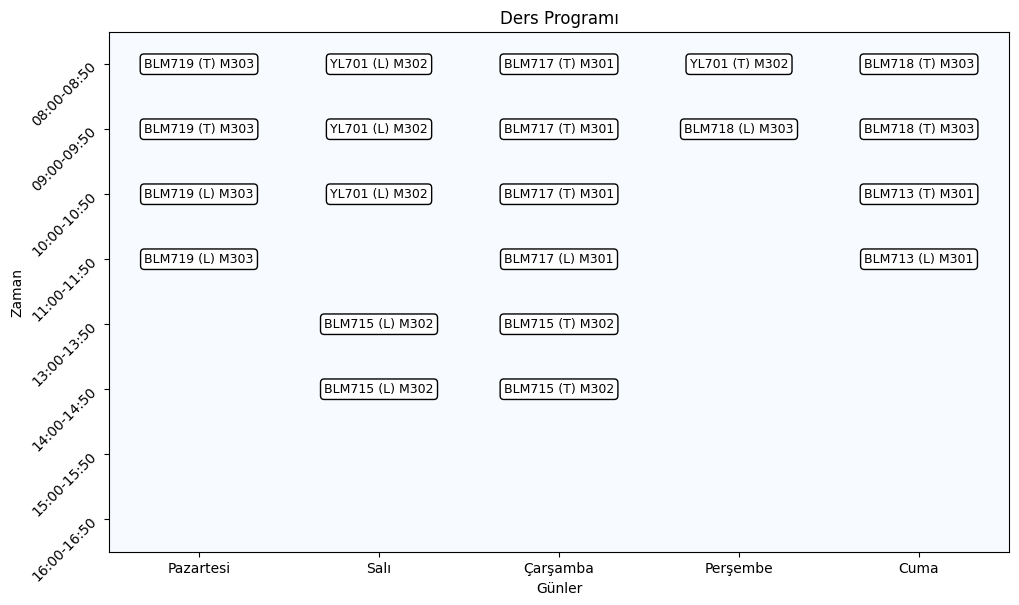

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# En iyi Genin Şema gösterimi
day_names = ["Pazartesi", "Salı", "Çarşamba", "Perşembe", "Cuma"]
unique_time_slots = sorted(set(ts.time_slot for ts in best_schedule.time_slots))

data = {day: [" " for _ in unique_time_slots] for day in day_names}
df = pd.DataFrame(data)
df.index = unique_time_slots

for course_code, details in best_schedule.schedule.items():
    room = details["room"]
    for slot in details["theory"]:
        if slot.day in df.columns:
            df.loc[slot.time_slot, slot.day] = f"{course_code} (T) {room.number}"
    for slot in details["lab"]:
        if slot.day in df.columns:
            df.loc[slot.time_slot, slot.day] = f"{course_code} (L) {room.number}"

fig, ax = plt.subplots(figsize=(12, 8))

heatmap = np.zeros(df.shape)
ax.imshow(heatmap, cmap="Blues", aspect="auto")

ax.set_xticks(np.arange(len(day_names)))
ax.set_yticks(np.arange(len(unique_time_slots)))
ax.set_xticklabels(day_names)
ax.set_yticklabels(unique_time_slots, rotation=45, ha="right")

for i in range(len(unique_time_slots)):
    for j in range(len(day_names)):
        text = df.iloc[i, j]
        if text.strip():
            ax.text(j, i, text, ha="center", va="center", color="black", fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.xlabel("Günler")
plt.ylabel("Zaman")
plt.title("Ders Programı")
plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.3)

plt.show()